# Decaying barotropic QG beta-plane turbulence


An example of decaying barotropic quasi-geostrophic turbulence on a beta plane.

In [1]:
using Pkg; Pkg.activate("."); Pkg.instantiate();

 Activating environment at `~/Teaching/CLExWinterSchool2020/simulations/Project.toml`


In [13]:
using FourierFlows, Plots, Printf, Random

using FFTW: irfft
using Random: seed!

import GeophysicalFlows.BarotropicQG
using GeophysicalFlows: peakedisotropicspectrum

## Numerical parameters and time-stepping parameters

In [26]:
     nx = 256            # 2D resolution = nx^2
stepper = "FilteredRK4"  # timestepper
     dt = 0.005          # timestep
 nsteps = 8000           # total number of time-steps
 nsubs  = 20;            # number of time-steps for intermediate logging/plotting (nsteps must be multiple of nsubs)

## Physical parameters

In [27]:
Lx = 2π        # domain size
 β = 14.0      # planetary PV gradient
 μ = 0.0;      # bottom drag

## Problem setup
We initialize a `Problem` by providing a set of keyword arguments. Not providing
a viscosity coefficient ν leads to the module's default value: `ν=0`. In this
example numerical instability due to accumulation of enstrophy in high wavenumbers
is taken care with the `FilteredTimestepper` we picked.

In [28]:
prob = BarotropicQG.Problem(nx=nx, Lx=Lx, β=β, μ=μ, dt=dt, stepper=stepper);

and define some shortcuts

In [30]:
sol, cl, vs, pr, gr = prob.sol, prob.clock, prob.vars, prob.params, prob.grid
x, y = gr.x, gr.y;

## Visualizing the simulation

We define a function that plots the vorticity and streamfunction fields and
their corresponding zonal mean structure.

In [32]:
function plot_output(prob)
  X, Y = gridpoints(prob.grid)

   ζ = prob.vars.zeta
   ψ = prob.vars.psi
  PV = (prob.vars.zeta .+ prob.params.β*Y)'

  ζ_plot = heatmap(x, y, ζ,
       aspectratio = 1,
            legend = false,
                 c = :balance,
              clim = (-20, 20),
             xlims = (-gr.Lx/2, gr.Lx/2),
             ylims = (-gr.Ly/2, gr.Ly/2),
            xticks = -3:3,
            yticks = -3:3,
            xlabel = "x",
            ylabel = "y",
             title = "vorticity ζ=∂v/∂x-∂u/∂y",
        framestyle = :box)

  PV_plot = heatmap(x, y, PV,
       aspectratio = 1,
            legend = false,
             xlims = (-gr.Lx/2, gr.Lx/2),
             ylims = (-gr.Ly/2, gr.Ly/2),
            xticks = -3:3,
            yticks = -3:3,
            xlabel = "x",
            ylabel = "y",
             title = "vorticity ζ+βy",
        framestyle = :box)

  layout = @layout grid(1, 2)
  p = plot(ζ_plot, PV_plot, layout = layout, size = (900, 500))

  return p
end;

## Setting initial conditions

Our initial condition consist of a flow that has power only at wavenumbers with
$8<\frac{L}{2\pi}\sqrt{k_x^2+k_y^2}<10$ and initial energy $E_0$:

In [51]:
Random.seed!(1234)
k₀ = 6   # central total wavenumber of initial condition 
E₀ = 0.5 # energy of initial condition

qi = peakedisotropicspectrum(gr, k₀, E₀, mask=prob.timestepper.filter);

Let's initialize our problem with this initial condition...

In [52]:
BarotropicQG.set_zeta!(prob, qi);

and let's plot it to see how it looks.

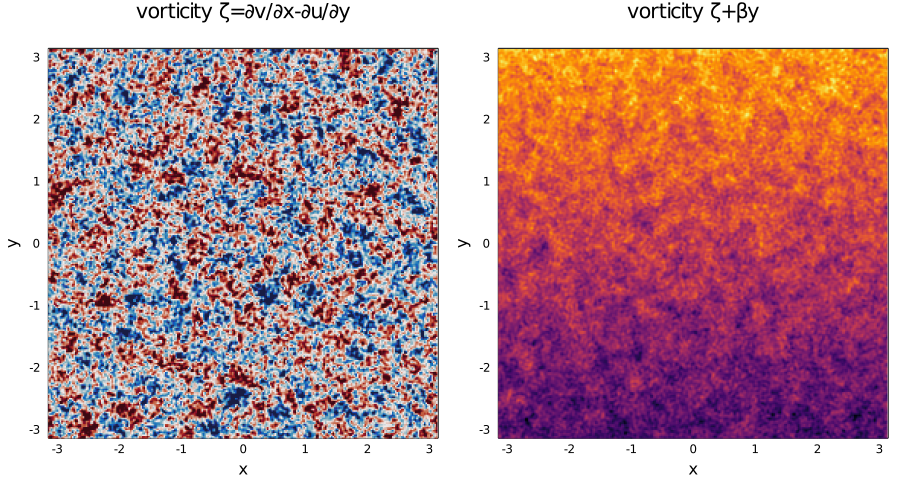

In [53]:
plot_output(prob)

## Time-stepping the `Problem` forward

We time-step the `Problem` forward in time. Every `nsubs` time-steps we update the plot and create an animation.

In [23]:
startwalltime = time()

X, Y = gridpoints(prob.grid)

p = plot_output(prob)

anim = @animate for j=0:Int(nsteps/nsubs)

  log = @sprintf("step: %04d, t: %d, walltime: %.2f min", cl.step, cl.t, (time()-startwalltime)/60)

  if j%(1000/nsubs)==0; println(log) end  
  
  # Update the subplots in the plot and their corresponding titles
  p[1][1][:z] = Array(vs.zeta)
  p[1][:title] = "vorticity, t=" * @sprintf("%.2f", cl.t)
  p[2][1][:z] = Array(vs.zeta .+ pr.β * Y)
  p[2][:title] = "PV, t=" * @sprintf("%.2f", cl.t)

  stepforward!(prob, nsubs)
  BarotropicQG.updatevars!(prob)

end

mp4(anim, "barotropicqg_betadecay.mp4", fps=24)

step: 0000, t: 0, walltime: 0.00 min
step: 1000, t: 10, walltime: 1.20 min
step: 2000, t: 20, walltime: 2.40 min
step: 3000, t: 30, walltime: 3.60 min
step: 4000, t: 40, walltime: 4.83 min


┌ Info: Saved animation to 
│   fn = /Users/navid/Teaching/CLExWinterSchool2020/simulations/barotropicqg_betadecay.mp4
└ @ Plots /Users/navid/.julia/packages/Plots/mXrnb/src/animation.jl:104


Plots.AnimatedGif("/Users/navid/Teaching/CLExWinterSchool2020/simulations/barotropicqg_betadecay.mp4")